<a href="https://colab.research.google.com/github/caavila96/Colombia_maps_SGR/blob/main/informalidad_GEIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto para la estimación de los determinantes de la informalidad laboral en Colombia.**

Para la generación de este proyecto se usará la base de datos de la Gran Encuesta Integrada de Hogares - GEIH 2022, esta base de datos es publicada por el Departamento Administrativo Nacional de Estadísticas - DANE de forma mensual (anonimizada) en diversos formatos.

Teniendo en cuenta esto se han subido los 12 meses a un respositorio en Github en formato .zip, cada uno de los formatos contiene un total de 9 tablas, a saber

*   Características generales, seguridad social en salud y educación 
*   Datos del hogar y la vivienda.
*   Fuerza de trabajo
*   Migración 
*   No ocupados
*   Ocupados
*   Otras formas de trabajo
*   Otros ingresos e impuestos
*   Tipo de investigación

Dado el objetivo de la investigación solo se tendran en cuenta tres bases, a saber:

*   Características generales, seguridad social en salud y educación 
*   Datos del hogar y la vivienda.
*   Fuerza de trabajo
*   Ocupados





## **1. Librerias a ser utilizadas**

In [141]:
!apt-get install git -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [142]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import requests #Descargar información Github
import io       #Herramientas principales para trabajar con streams
from zipfile import ZipFile #Apertura de los zip file
from functools import reduce #Usado para pegar las tablas
import gc #Limpiar memoria


import warnings
warnings.filterwarnings("ignore", category=UnicodeWarning) #ignorar erroes de UTF-8 y Latin-1
warnings.filterwarnings("ignore") 

## **2. Impotar información y filtro inicial de variables.**

Para ello se descarga cada uno de los meses se hace el pegue de las bases, se gudarda en el disco temporal y posteriormente se unen los 12 meses. Para que la salida final no genera una base de datos tan pesada se creará una lista (collist) la cual contendrá las variables seleccionadas para el presente análisis. 

In [143]:

#Se crea una lista vacía para guardar la base por cada mes
year = []
#Se crea una lista con los meses del 01 hasta el 12 string
month = []
for i in range(1, 13):
  month.append(str(i).zfill(2))

for m in month:

  #url de Github donde se encuentran los datos
  url = " https://github.com/caavila96/Informalidad_GEIH_2022/blob/33c817cad9cc205dbb6ebd8f935b2c2e1612bd14/BASE/"+ m + ".zip?raw=true"


  # Descarga de los datos de Github
  response = requests.get(url)
  data = io.BytesIO(response.content)

  # Se define una lista que contiene los nombres de las tablas que serán utilizadas
  tables = ['Características generales, seguridad social en salud y educación.dta',
                    'Datos del hogar y la vivienda.dta',
                    'Fuerza de trabajo.dta',
                    'Migración.dta',
                    'Ocupados.dta']

  # Se crea una lista donde se cargaran todas las tablas definidas
  dfs = []

  # Se extraen todos los datos definidos en la lista tables
  with ZipFile(data, "r") as zip_ref:
      for file in zip_ref.namelist():
          if any(file.endswith(f) for f in tables):
              with zip_ref.open(file) as f:
                  df = pd.read_stata(f, convert_categoricals=False)
                  df.columns = df.columns.str.upper()
                  df["MES"] = m
                  dfs.append(df)

  ##Se crea una lista de data frames con las bases de persona
  p_df =[df for j, df in enumerate(dfs) if j != 1]

  #Se realiza el pegue de las bases a nivel de persona, se crea un sufijo para eliminar las variables duplicadas
  p_df = reduce(lambda df1,df2: pd.merge(df1,df2,on=["DIRECTORIO","SECUENCIA_P","ORDEN"], how = "left",suffixes=('', '_remove')),  [df for j, df in enumerate(dfs) if j != 1])

  # Se realiza el pegue de las bases de personas con la base de vivienda y hogares
  t_df = pd.merge(p_df,dfs[1],on=["DIRECTORIO","SECUENCIA_P"], how = "left",suffixes=('', '_remove'))

  #Se remueven las variables duplicadas
  t_df.drop([i for i in t_df.columns if 'remove' in i],
                axis=1, inplace=True)
  
  #Se realiza el filtro de la lista de variable seleccionadas
  collist = ["DIRECTORIO","SECUENCIA_P","ORDEN","MES","CLASE","AREA","DPTO","P3271","P6040","P6050","P6080", "P3042","P3042S1","P3043","OCI",
 "P3069","P6426","OFICIO_C8","P6430","RAMA2D_R4","P3045S1","P3046","P3069","P3065","P3066","P6765","OFICIO_C8","P3067",
 "P3067S1","P3067S2","P6775","P3068","P6100","P6110","P6450","P6920","P6930","P6940","P3373","P3373S3","P3373S3A1",
 "P3373S3A2","P3382","P3382S3","P3384","P3384S3","FEX_C18"]
 
  t_df = t_df.filter(items = collist, axis = 1)

  #Se guarda la base de datos en la lista 
  year.append(t_df)

#Se crea una función para unir todas las tablas teniendo en cuenta el nombre de la variable
def unionByName(df1, df2):
    common_cols = df1.columns.intersection(df2.columns)
    combined_df = pd.concat([df1[common_cols], df2[common_cols]], ignore_index=True)
    return combined_df

# Se aplica a toda la lista de años 
df_final  = reduce(unionByName, year)

# Se elimina la lista de años y se limpia la memoria RAM
del year
gc.collect()

1351

In [144]:
#Cantidad de observaciones y expansión

df_final.groupby(["MES"]).agg(TOT_PER = ('DIRECTORIO', 'count'), 
                              TOT_PER_EXP = ('FEX_C18', 'sum'))

,TOT_PER,TOT_PER_EXP
MES,,
01,80116,50254112.0
02,79783,50299304.0
03,78595,50339835.0
04,77679,50384974.0
05,77380,50428727.0
06,77999,50474569.0
07,75963,50513027.0
08,76625,50559226.0
09,75382,50605026.0


## **3. Ajuste de variables y filtro de observaciones.**

Si bien se ha generado un filtro inicial de las variables es necesario realizar una serie de transformaciones para algunas de las variable, los primero que se realizará es el ajuste de los formatos de las variables, posteriormente se generaran variables a nivel de hogar variables compuestas (informalidad, años de educación) para posteriomente generar el filtro de observaciones y variables para tener la base final.

### 3.1 Ajuste de formatos. 

Los formatos se deben ajustar dado que durante la importación muchos de los valores que son int son float. Por este motivo se debe realizar este ajuste

In [145]:
# dtypes iniciales
df_final.dtypes

DIRECTORIO     float64
SECUENCIA_P    float64
ORDEN          float64
MES             object
CLASE           object
AREA            object
DPTO            object
P3271          float64
P6040          float64
P6050          float64
P6080          float64
P3042          float64
P3042S1        float64
P3043          float64
OCI            float64
P3069          float64
P3069          float64
P6426          float64
OFICIO_C8       object
OFICIO_C8       object
P6430          float64
RAMA2D_R4       object
P3045S1        float64
P3046          float64
P3065          float64
P3066          float64
P6765          float64
P3067          float64
P3067S1        float64
P3067S2        float64
P6775          float64
P3068          float64
P6100          float64
P6110          float64
P6450          float64
P6920          float64
P6930          float64
P6940          float64
P3373          float64
P3373S3        float64
P3373S3A1      float64
P3373S3A2      float64
P3382          float64
P3382S3    

In [146]:
# Se genera el cambio de los dtypes
df_final = df_final.convert_dtypes()
df_final.dtypes

DIRECTORIO       Int64
SECUENCIA_P      Int64
ORDEN            Int64
MES             string
CLASE           object
AREA            object
DPTO            object
P3271            Int64
P6040            Int64
P6050            Int64
P6080            Int64
P3042            Int64
P3042S1          Int64
P3043            Int64
OCI              Int64
P3069            Int64
P3069            Int64
P6426            Int64
OFICIO_C8       object
OFICIO_C8       object
P6430            Int64
RAMA2D_R4       object
P3045S1          Int64
P3046            Int64
P3065            Int64
P3066            Int64
P6765            Int64
P3067            Int64
P3067S1          Int64
P3067S2          Int64
P6775            Int64
P3068            Int64
P6100            Int64
P6110            Int64
P6450            Int64
P6920            Int64
P6930            Int64
P6940            Int64
P3373            Int64
P3373S3          Int64
P3373S3A1        Int64
P3373S3A2        Int64
P3382            Int64
P3382S3    

In [147]:
df_final

,DIRECTORIO,SECUENCIA_P,ORDEN,MES,CLASE,AREA,DPTO,P3271,P6040,P6050,...,P6940,P3373,P3373S3,P3373S3A1,P3373S3A2,P3382,P3382S3,P3384,P3384S3,FEX_C18
0,5000000,1,1,01,1,,08,1,33,1,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
1,5000000,1,2,01,1,,08,2,31,2,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
2,5000000,1,3,01,1,,08,2,11,3,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
3,5000000,1,4,01,1,,08,2,5,3,...,<NA>,3,862,2019,12,4,862,2,<NA>,1432.463323
4,5000000,1,5,01,1,,08,1,3,3,...,<NA>,3,862,2019,12,1,<NA>,2,<NA>,1432.463323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919454,7309049,1,3,12,1,,99,2,14,3,...,<NA>,1,<NA>,<NA>,<NA>,2,<NA>,2,<NA>,25.636473
919455,7309050,1,1,12,1,,99,1,53,1,...,<NA>,1,<NA>,<NA>,<NA>,2,<NA>,2,<NA>,25.167948
919456,7309050,1,2,12,1,,99,2,30,2,...,<NA>,3,862,2015,2,2,<NA>,2,<NA>,25.167948
919457,7309050,1,3,12,1,,99,1,11,3,...,<NA>,3,862,2015,2,2,<NA>,2,<NA>,25.167948


### 3.2 Creación de variables a nivel de hogar.

Algunas de las variables y caraccteristicas del hogar pueden estar correlacionadas con la informalidad, por este motivo se crearán las siguientes variables:

* **NPER:** Cantidad de personas en el hogar
* **NPER_5:** Cantidad de personas de 0 a 5 años
* **NPER_17:** Cantidad de personas de 6 a 17 años
* **NPER_60:** Cantidad de personas mayores de 60 años
* **NPER_OCU:** Cantiad de personas ocuapdas

In [148]:
#Se generan las variables en una tabla df_hog

#Menores de 5 años
df_final["PER_5"] = np.where(df_final["P6040"] <= 5, 1, 0)
#De 6 a 17 años
df_final["PER_17"] = np.where((df_final['P6040'] > 5) & (df_final['P6040'] <= 17) , 1, 0)
#De meyores de 60 años
df_final["PER_60"] = np.where(df_final['P6040'] > 60  , 1, 0)
#De meyores de 60 años
df_final["PER_OCU"] = np.where( pd.notnull(df_final["OCI"]), 1, 0)


#Se agregan a nivel de hogar
df_hog = df_final.groupby(["DIRECTORIO","SECUENCIA_P"]).agg(NPER = ('DIRECTORIO', 'count'), 
                                                 NPER_5 = ('PER_5', 'sum'),
                                                 NPER_17 = ('PER_17', 'sum'),
                                                 NPER_60 = ('PER_60', 'sum'),
                                                 NPER_OCU = ('PER_OCU', 'sum'))

#Se eliminan las variables creadas de la tabla df_final
df_final = df_final.drop(['PER_5', 'PER_17', 'PER_60', 'PER_OCU'], axis=1)

#Se realiza el pegue de la base de datos
df_final = df_final.merge(df_hog, on=['DIRECTORIO','SECUENCIA_P'] , how = 'inner')

### 3.3 Filtro de observaciones

La informalidad al ser un fenómeno presente únicamente en las personas que se encuentran ocupados al interior del mercado laboral, por tal motivo la cantidad de personas que serán parte del estudio se reduce, cabe resaltar que la GEIH encuesta a todas las personas de los hogares seleccionados, esto implica que hay personas ocupadas, no ocupadas e inactivas. 

Para evitar esto se realiza el filtro de las personas ocupadas.

In [149]:
#Filtro de las personas ocupadas
df_final = df_final[pd.notnull(df_final["OCI"])]

In [150]:
#Cantidad de ocupados y ocupados expandidos
df_final.groupby(["MES"]).agg(TOT_OCU = ('DIRECTORIO', 'count'), 
                              TOT_OCU_EXP = ('FEX_C18', 'sum'))

,TOT_OCU,TOT_OCU_EXP
MES,,
01,31819,20695784.878253
02,32979,21680919.300128
03,32875,21679829.20059
04,31914,21957394.726572
05,32538,22184762.155964
06,32522,22022595.662033
07,31531,22055061.724591
08,31820,22160002.623957
09,31867,22389333.537601


### 3.4 Generación de variables adicionales.

Para cumplir con el objetivo del estudio es necesario agregar variables adicionales que no se encuentran en la base inicial, estas son:

*  **FORMAL**: tendrá un valor de 1 si la persona es un ocupado formal y 0 si es informal
*  **A_EDUC**: Cantidad de años de educación cursados y aprobados por la persona
*  **FEX_A**: promedio ponderado de los factores de expansión para la generación de resultados anuales.
* **FEX_T**: : promedio ponderado de los factores de expansión para la generación de resultados trimestrales.
* **RAMA**: : Rama de actividad a dos dígitos.



In [151]:
#DEFINICION DE VARIABLES:
vars_infor = ["ANO","OFICIO_C8","P6430","RAMA2D_R4","P3046","P3045S1","P3069","P6765","P3065","P3066","P3067","P3067S1",
              "P3067S2","P6775","P3068","P6100","P6110","P6920","P6930","P6940","P6450"]

def informalidad(args):
  ANO,OFICIO_C8,P6430,Rama2d_R4,P3046,P3045S1,P3069,P6765,P3065,P3066,P3067,P3067S1,P3067S2,P6775,P3068,P6100,P6110,P6920,P6930,P6940,P6450 = args

  ANIOS = (ANO-1)
  if isinstance(OFICIO_C8, str):   OFICIO_C8_2D = OFICIO_C8[:2]
  if isinstance(OFICIO_C8, float): OFICIO_C8_2D = str(int(OFICIO_C8)).zfill(4)[:2]

  if   P6430 == 3: FORMAL = np.nan
  elif P6430 == 6: FORMAL = 0
  elif Rama2d_R4 in (84,99): FORMAL=1 
  elif P6430 == 8: FORMAL = 0

  #ASALARIADOS:
  elif P6430 == 2: FORMAL=1 
  elif P6430 in (1,7) and P3045S1==1: FORMAL=1 
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 1: FORMAL=1
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 2: FORMAL=0
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 9 and (P3069 >= 4): FORMAL=1
  elif P6430 in (1,7) and P3045S1 in (2,9) and P3046 == 9 and (P3069 <= 3): FORMAL=0

  #INDEPENDIENTES:
    #Sin NEGOCIO:
  elif P6430 in (4,5) and P6765 !=7  and P3065 == 1 : FORMAL=1
  elif P6430 in (4,5) and P6765 !=7  and P3065 in (2,9) and P3066 == 1: FORMAL=1
  elif P6430 in (4,5) and P6765 !=7  and P3065 in (2,9) and P3066 == 2: FORMAL=0
  elif P6430 == 5     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and P3069 >= 4: FORMAL=1
  elif P6430 == 5     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and P3069 <= 3: FORMAL=0
  elif P6430 == 4     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20'): FORMAL=1
  elif P6430 == 4     and P6765 != 7 and P3065 in (2,9) and P3066 == 9 and (OFICIO_C8_2D >='21'): FORMAL=0

    #CON NEGOCIO:
      #RENOVARON REGISTRO:
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==1 and P3067S2 >= ANIOS: FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==1 and P3067S2 < ANIOS: FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775 == 1: FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775 == 3 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775 == 3 and (OFICIO_C8_2D >='21') : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==2 : FORMAL=0
  elif P6430 == 4     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 == 4     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and (OFICIO_C8_2D >='21') : FORMAL=0
  elif P6430 == 5     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and P3069 >= 4 : FORMAL=1
  elif P6430 == 5     and P6765 == 7 and P3067==1 and P3067S1==2 and P6775==9 and P3069 <= 3 : FORMAL=0
  
      #NO RENOVARON REGISTRO:
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 1 and P3068==1 : FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 1 and P3068==2 : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 3 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775 == 3 and (OFICIO_C8_2D >='21') : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775==1 and P3068==9 : FORMAL=0
  elif P6430 in (4,5) and P6765 == 7 and P3067==2 and P6775==2: FORMAL=0
  elif P6430 == 5     and P6765 == 7 and P3067==2 and P6775==9 and P3069 >= 4 : FORMAL=1
  elif P6430 == 5     and P6765 == 7 and P3067==2 and P6775==9 and P3069 <= 3 : FORMAL=0
  elif P6430 == 4     and P6765 == 7 and P3067==2 and P6775==9 and (OFICIO_C8_2D >='00'  and OFICIO_C8_2D <='20') : FORMAL=1
  elif P6430 == 4     and P6765 == 7 and P3067==2 and P6775==9 and (OFICIO_C8_2D >='21') : FORMAL=0

  #OCUPACION inFORMAL:
  
  #SALUD:
  if   P6430 in (1,3,7) and P6100 in (1,2) and P6110 in (1,2,4): SALUD=1
  elif P6430 in (1,3,7) and P6100==9 and P6450==2: SALUD=1
  elif P6430 in (1,3,7) and P6110==9 and P6450==2: SALUD=1
  elif P6430 in (1,3,7): SALUD=0

  # #PENSIÓN:
  if   P6430 in (1,3,7) and P6920==3: PENSION=1
  elif P6430 in (1,3,7) and P6920==1 and P6930 in (1,2,3) and P6940 in (1,3): PENSION=1
  elif P6430 in (1,3,7): PENSION=0

  #OCUPACION INFORMAL:
  if   P6430 == 2: EI=1
  elif P6430 in (6,8): EI=0
  elif P6430 in (4,5): EI=FORMAL
  elif P6430 in (1,3,7) and SALUD==1 and PENSION==1: EI=1
  elif P6430 in (1,3,7): EI=0

  return EI

def educacion(args):
  P3042,P3042S1 = args
  
  if P3042 in (7,8,9,10,11,12,13): P3042S1_ = P3042S1/2
  else:                            P3042S1_ = P3042S1
  
  #AÑOS EDUCACION:
  if   (P3042 == 4 and P3042S1_ == 0): a_educ=5
  elif (P3042 == 4 and P3042S1_ != 0): a_educ=5+P3042S1_
  elif P3042 in (1,2,3):               a_educ=P3042S1_
  elif P3042 in (5,6):                 a_educ=9+P3042S1_
  elif P3042 in (7,8,9,10):            a_educ=11+P3042S1_
  elif P3042 in (11,12):               a_educ=16+P3042S1_
  elif P3042 == 13:                    a_educ=18+P3042S1_
  elif P3042 == 99:                    a_educ = np.nan
  else:                                a_educ = np.nan
  return a_educ

def rama2d(rama2d_R4):

  if   rama2d_R4 in (1,2,3) : Rama=1
  elif rama2d_R4 in (5,6,7,8,9) : Rama=2
  elif rama2d_R4 in (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) : Rama=3
  elif rama2d_R4 in (35,36,37,38,39) : Rama=4
  elif rama2d_R4 in (41,42,43) : Rama=5
  elif rama2d_R4 in (45,46,47) : Rama=6
  elif rama2d_R4 in (55,56) : Rama=7
  elif rama2d_R4 in (49,50,51,52,53) : Rama=8
  elif rama2d_R4 in (58,59,60,61,62,63) : Rama=9
  elif rama2d_R4 in (64,65,66) : Rama=10
  elif rama2d_R4 == 68 : Rama=11
  elif rama2d_R4 in (69,70,71,72,73,74,75,77,78,79,80,81,82) : Rama=12
  elif rama2d_R4 in (84,85,86,87,88) : Rama=13
  elif rama2d_R4 in (90,91,92,93,94,95,96,97,98,99) : Rama=14
  elif rama2d_R4 == 00 : Rama=15
  return Rama

def fex_a(FEX_C18):
  return FEX_C18/12

def fex_t(FEX_C18):
  return FEX_C18/3

In [152]:
#ELIMINANDO COLUMNAS DUPLICADAS
df_final = df_final.loc[:,~df_final.columns.duplicated()]

In [153]:
#DEFINIENDO FLOAT DE VARIABLES:
df_final['P6100']     = df_final['P6100'].astype(float)
df_final['P6110']     = df_final['P6110'].astype(float)
df_final['RAMA2D_R4'] = df_final['RAMA2D_R4'].astype(float)
df_final['P3042']     = df_final['P3042'].astype(float)
df_final['P3042S1']   = df_final['P3042S1'].astype(float)

In [154]:
#VARIABLES:
df_final["ANO"]    = 2022
df_final["fex_a"]  = df_final["FEX_C18"].apply(fex_a)
df_final["fex_t"]  = df_final["FEX_C18"].apply(fex_t)
df_final["rama"]   = df_final["RAMA2D_R4"].apply(rama2d)
df_final["infor"]  = df_final[vars_infor].apply(informalidad, axis=1)
df_final["a_educ"] = df_final[['P3042','P3042S1']].apply(educacion, axis=1)

### 3.5 Homogenización del nombre de las variables

Una vez se han realizado la generación de las variables se homogeniza todas las variables a minuscula para un uso más sencillo.

In [155]:
df_final.columns= df_final.columns.str.lower()

### 3.6 Filtro de variables finales a utilizar. 

Una vex se ha generado las variables compuestas se realizan los filtros para tener un dataframe únicamente con las variables importantes para el análisis de la información, estas son:



*   Variables llave (**directorio**, **secuencia_p**, **orden**)
*   **mes**: Mes de la encuesta
*   **clase**: Variable que determina si la persona encuestada vive en la cabecera o en centro poblado o rural disperso del municipio.
*   **area**: Identifica si la persona vive en alguna de las 23 ciudades principales o sus area metropolitanas.
*  **dpto**: Deparamento en el cual vive la persona encuestada
*  **p3271**: Sexo al nacer
*  **p6040**: Edad
*  **p6050**: Parentesco con el jefe del hogar
*  **p3069**: Cantidad de empleados en la empresa donde trabaja
*  **p3373**: Lugar de nacimiento
*  **p3382**: Dondé vivia hace 5 años
*  **p3384**: Dónde vivía hace 12 meses
*  **fex_c18**: Factor de expansión mensual
*  **nper**: Cantidad de personas en el hogar
*  **nper_5**: Cantidad de personas de 5 años o menos en el hogar
*  **nper_17**: Cantidad de perosnas de 17 años o menos en el hogar
*  **nper_60**: Cantidad de personas mayores de 60 años
*  **nper_OCU**: Cantidad de personas ocupadas al interior del hogar
*  **fex_a**: Factor de expansión anua
*  **fex_t**: Factor de expansión trimestral
*  **rama**: Rama de actividad en grandes grupos
*  **infor**: Informalidad
*  **a_educ**: Años de educación 



In [157]:
df_final = df_final[['directorio', 'secuencia_p', 'orden','ano', 'mes', 'clase', 'area', 'dpto','p3271',
 'p6040', 'p6050', 'p6080','p3069','p3373','p3382','p3384','fex_c18','nper','nper_5',
 'nper_17','nper_60','nper_ocu','fex_a','fex_t','rama','infor','a_educ']]

### 3.7 Ajuste final de varibles

Al realizar los ajustes en el punto 3.1 hubo algunas variables que fueron revisadas posteriormente y tienen valores en diversos formatos. a continuación se realizará el ajuste de cada una de ellas. 

In [158]:
#Variable clase
df_final['clase'] = df_final['clase'].astype("int")

# Variable area
df_final['area'] = df_final['area'].replace("", None)
df_final['area'] = df_final['area'].astype("str")

def mpio_divi(mpio):
  if (mpio == '5') or (mpio == '8') :
    return '0' + mpio
  else:
    return mpio

df_final['area'] = df_final['area'].apply(mpio_divi)

#Variable dpto
df_final['dpto'] = df_final['dpto'].astype("str")
df_final['dpto'] = df_final['dpto'].apply(mpio_divi)


In [159]:
warnings.filterwarnings("default") #activas de nuevo los warnings

## **4. Estadísticas descriptivas**

A continuación se presentaran algunas estáidisticas descriptivas para cada una de las variables seleccionadas, también se realizarán visualizaciónes de los datos y como se correlacionan con la variable de informalidad

### 4.1 Informalidad

La primera variable que se analizará es la variable ojeto de estudio, de igual forma se comprarán con los resultados publicados por el DANE en su página  [web](https://https://www.dane.gov.co/index.php/estadisticas-por-tema/salud/informalidad-y-seguridad-social/empleo-informal-y-seguridad-social-historicos) para poder tener certeza que todos los cálculos fueron efectivamente realizados.  

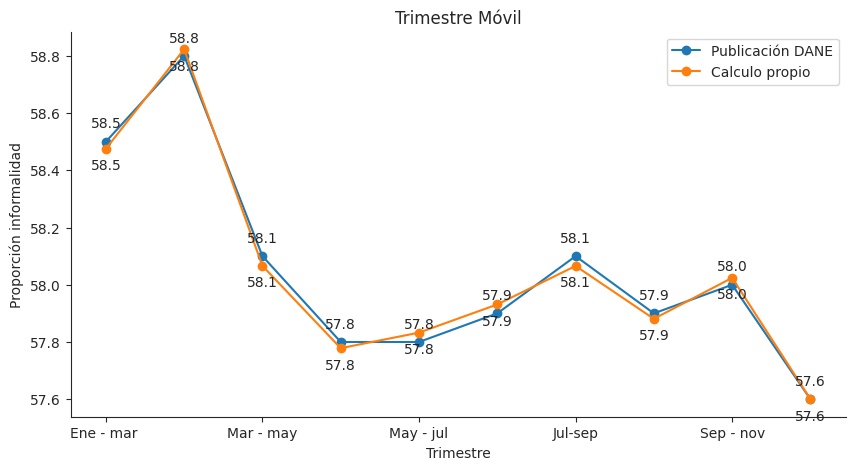

In [235]:
''' 
El DANE presenta la información de informalidad de forma trimestre corrido, por este motivo se agrupan los resultados por trimestrre corrido usando el factor de expansión
trimestral. 

Posterior a esto se agregan los resultados DANE para tener una comparabilidad

'''
trimestre_movil = [["01", "02", "03"], ["02", "03", "04"], ["03", "04", "05"], ["04", "05", "06"], ["05", "06", "07"], ["06", "07", "08"], ["07", "08", "09"], ["08", "09", "10"], ["09", "10", "11"], ["10", "11", "12"]]

trim_movi = pd.DataFrame()

for trimestre in trimestre_movil:
    resultado = df_final[(df_final['mes'].isin(trimestre)) & (df_final['area'].notna()) ].groupby('ano').apply(lambda x: (1-((x['infor'] * x['fex_t']).sum() / x['fex_t'].sum()))*100 )
    trim_movi = pd.concat([trim_movi, resultado], axis=1)

trim_movi.columns = ['Ene - mar ', 'Feb - abr ', 'Mar - may', 'Abr - Jun', 'May - jul', 'Jun-ago', 'Jul-sep', 'Ago-oct', 'Sep - nov', 'Oct -dic']

trim_movi.loc['2022_DANE'] = [58.5,	58.8,	58.1,	57.8,	57.8,	57.9,	58.1,	57.9,	58.0,	57.6]


#generación de linea que compare los dos resultados 

# tamaño
fig, ax = plt.subplots(figsize=(10, 5))

#transposición de la tabla 
trim_movi = trim_movi.T

# Linea de resultado DANE
trim_movi['2022_DANE'].plot(kind='line', marker='o', label='Publicación DANE', ax=ax)

# Línea de resultado propio
trim_movi[2022].plot(kind='line', marker='o', label='Calculo propio', ax=ax)

# Corte eje y

# labels
plt.title('Trimestre Móvil')
plt.xlabel('Trimestre')
plt.ylabel('Proporción informalidad')

# Puntos de datos primera línea
for i, value in enumerate(trim_movi[2022]):
    ax.annotate(f'{value:.1f}', (i, value), textcoords="offset points", xytext=(0, -15), ha='center')

#Puntos de datos segunda linea 
for i, value in enumerate(trim_movi['2022_DANE']):
    ax.annotate(f'{value:.1f}', (i, value), textcoords="offset points", xytext=(0, 10), ha='center')

# Remove the top and right spines
sns.despine()

# Display the legend
ax.legend(fontsize=12)


ax.legend()

plt.show()

In [171]:
df_final[(df_final['mes'].isin(trimestre)) & (df_final['area'].notna())]

,directorio,secuencia_p,orden,ano,mes,clase,area,dpto,p3271,p6040,...,nper,nper_5,nper_17,nper_60,nper_ocu,fex_a,fex_t,rama,infor,a_educ
699522,7215433,1,1,2022,10,1,05,05,1,48,...,3,1,0,0,2,219.870005,879.480019,6,0,14.0
699523,7215433,1,2,2022,10,1,05,05,2,26,...,3,1,0,0,2,219.870005,879.480019,12,0,11.0
699525,7215434,1,1,2022,10,1,05,05,2,48,...,8,1,3,0,3,278.932911,1115.731646,14,0,8.0
699526,7215434,1,2,2022,10,1,05,05,1,44,...,8,1,3,0,3,278.932911,1115.731646,6,0,6.0
699528,7215434,1,4,2022,10,1,05,05,1,39,...,8,1,3,0,3,278.932911,1115.731646,5,0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919449,7309048,1,2,2022,12,1,66,66,1,54,...,4,0,1,0,3,30.472607,121.890427,2,1,11.0
919450,7309048,1,3,2022,12,1,66,66,1,28,...,4,0,1,0,3,30.472607,121.890427,13,1,16.0
919452,7309049,1,1,2022,12,1,None,99,2,43,...,3,0,1,0,1,2.136373,8.545491,6,1,13.0
919455,7309050,1,1,2022,12,1,None,99,1,53,...,4,1,1,0,2,2.097329,8.389316,8,0,5.0


In [172]:
df_final

,directorio,secuencia_p,orden,ano,mes,clase,area,dpto,p3271,p6040,...,nper,nper_5,nper_17,nper_60,nper_ocu,fex_a,fex_t,rama,infor,a_educ
0,5000000,1,1,2022,01,1,None,08,1,33,...,6,2,1,1,1,119.371944,477.487774,6,0,11.0
6,5000001,1,1,2022,01,1,None,08,1,58,...,3,0,0,1,3,90.733022,362.932089,8,0,5.0
7,5000001,1,2,2022,01,1,None,08,2,61,...,3,0,0,1,3,90.733022,362.932089,6,0,5.0
8,5000001,1,3,2022,01,1,None,08,1,36,...,3,0,0,1,3,90.733022,362.932089,8,0,5.0
9,5000002,1,1,2022,01,1,None,08,2,20,...,3,2,0,0,1,172.226035,688.904141,7,0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919449,7309048,1,2,2022,12,1,66,66,1,54,...,4,0,1,0,3,30.472607,121.890427,2,1,11.0
919450,7309048,1,3,2022,12,1,66,66,1,28,...,4,0,1,0,3,30.472607,121.890427,13,1,16.0
919452,7309049,1,1,2022,12,1,None,99,2,43,...,3,0,1,0,1,2.136373,8.545491,6,1,13.0
919455,7309050,1,1,2022,12,1,None,99,1,53,...,4,1,1,0,2,2.097329,8.389316,8,0,5.0
